In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd
import seaborn as sns

# visualization
import matplotlib.pyplot as plt

# machine learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB # Gaussian Naive Bays
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# evaluation
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from sklearn import preprocessing

from sklearn.metrics import precision_recall_curve, precision_score, recall_score, accuracy_score, roc_curve, roc_auc_score, f1_score
from sklearn.model_selection import GridSearchCV


In [2]:
# cleaned in script 'clean_features_demographic.ipynb'
df_demo = pd.DataFrame.from_csv('data_clean/phase_2/demographic_features.csv').reset_index()

# diabetes data
df_d = pd.DataFrame.from_csv('data_clean/phase_2/diabetes_class.csv').reset_index()

# body measures data
# features: waist, height, weight, BMI
df_bm = pd.DataFrame.from_csv('data_clean/phase_2/body_measure_features.csv').reset_index()

# medical condition data
# features: blood_relative_have_diabetes
df_mc = pd.DataFrame.from_csv('data_clean/phase_2/mc_features.csv').reset_index()

# exercise data
df_ex = pd.DataFrame.from_csv('data_clean/phase_2/exercise_features_cluster_5.csv')

# nutritional data
df_n = pd.DataFrame.from_csv('data_clean/phase_2/nutrition_features.csv').reset_index()

# blood pressure and cholesterol data
df_bpc = pd.DataFrame.from_csv('data_clean/phase_2/bpc_features.csv').reset_index()

# physical activity questionnaire data
df_paq = pd.DataFrame.from_csv('data_clean/phase_2/paq_features.csv').reset_index()

In [3]:
# change 1.0 "borderline" to 0.0
# create 'has_diabetes' column. 0 = not diabetic, 1 = diabetic
# considered diabetic if either diagnosed or past glucose threshold

df_d.loc[df_d['diabetes_known'] == 2.0, 'combined_diabetic'] = 1.0
df_d.loc[df_d['diabetic'] == 2.0, 'combined_diabetic'] = 1.0
df_d['combined_diabetic'].fillna(0.0, inplace = True);

df_d = pd.get_dummies(df_d, columns=['combined_diabetic'])

In [4]:
df_c = pd.merge(df_d, df_demo, how='inner', on='respondent_id')  # inner join
df_c = pd.merge(df_c, df_bm, how='inner', on='respondent_id')  # inner join
#df_c = pd.merge(df_c, df_n, how='inner', on='respondent_id')  # inner join
df_c = pd.merge(df_c, df_mc, how='inner', on='respondent_id')  # inner join
df_c = pd.merge(df_c, df_paq, how='inner', on='respondent_id')  # inner join
#df_c = pd.merge(df_c, df_bpc, how='inner', on='respondent_id')  # inner join
#df_c = pd.merge(df_c, df_ex, how='inner', on='respondent_id') # inner join
df_c.shape

(5340, 29)

In [5]:
# remove pregnant women, as hormones affect blood levels
# remove people under age of 20
pregnant_index = df_c[df_c['pregnancy_status_at_exam'] == 1.0].index.tolist()
age_index = df_c[df_c['age_at_screening'] < 20.0].index.tolist()

[pregnant_index.append(i) for i in age_index]
drop_index = list(set(pregnant_index))

df_c.drop(labels = drop_index, axis = 0, inplace = True)

# fill non-respondents of binary questions as no

df_c = df_c.fillna(0.0)

In [6]:
df_c.columns

Index(['respondent_id', 'diabetes_known', 'diabetic', 'combined_diabetic_0.0',
       'combined_diabetic_1.0', 'age_at_screening', 'annual_family_income',
       'annual_household_income', 'pregnancy_status_at_exam',
       'total_number_of_people_in_the_household', 'gender_1.0', 'gender_2.0',
       'race_ethnicity_1.0', 'race_ethnicity_2.0', 'race_ethnicity_3.0',
       'race_ethnicity_4.0', 'race_ethnicity_5.0', 'body_mass_index_kg_m**2',
       'standing_height_cm', 'weight_kg', 'waist_circumference_cm',
       'subscapular_skinfold_mm', 'upper_leg_length_cm',
       'blood_relatives_have_diabetes_0.0',
       'blood_relatives_have_diabetes_1.0',
       'avg_level_of_physical_activity_each_day_1.0',
       'avg_level_of_physical_activity_each_day_2.0',
       'avg_level_of_physical_activity_each_day_3.0',
       'avg_level_of_physical_activity_each_day_4.0'],
      dtype='object')

In [7]:
df_c['combined_diabetic_1.0'].value_counts()

0    3436
1     598
Name: combined_diabetic_1.0, dtype: int64

In [8]:
drop_col = list(df_d.columns.values)
drop_col.append('pregnancy_status_at_exam')

X = df_c.drop(drop_col, axis = 1)
Y = df_c['combined_diabetic_1.0'].copy()

In [9]:
x_train_raw, x_test_raw, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
x_train = scaler.fit_transform(x_train_raw)
x_test = scaler.fit_transform(x_test_raw)

In [10]:
def predict_threshold(model, x, threshold):
    return (model.predict_proba(x)[:,1] > threshold).astype(int)    

In [11]:
def print_confusions(model, x, y, y_pred):
    conf_train = pd.DataFrame(data=confusion_matrix(y, y_pred), 
                          columns=[0, 1],
                          index=[0, 1]).iloc[::-1,::-1].T

    print('Confusion (rows: pred, cols: actual)\n{}'.format(conf_train))

In [12]:
def print_eval(model, x, y, threshold=None):
    """Prints some evaluation metrics"""
    if threshold is not None:
        y_pred = predict_threshold(model, x, threshold)
    else:
        y_pred = model.predict(x)
    print('{:15} {:.5f}'.format('Accuracy:', accuracy_score(y, y_pred)))
    print('{:15} {:.5f}'.format('Precision:', precision_score(y, y_pred)))
    print('{:15} {:.5f}'.format('Recall:', recall_score(y, y_pred)))
    print('{:15} {:.5f}'.format('AUC:', roc_auc_score(y, y_pred)))
    print('{:15} {:.5f}'.format('F1 score:', f1_score(y, y_pred)))    
    print('')
    print_confusions(model, x, y, y_pred)

In [13]:
# print recall curves vs threshold and precision

def plot_precision_recall_curve(model, x, y):
    precision, recall, thresholds = precision_recall_curve(y_true = y, probas_pred = model.predict_proba(x)[:,1])
    fpr, tpr, threshold = roc_curve(y_test, model.predict_proba(x)[:,1])
    
    # ROC curve
    fig, ax = plt.subplots(1,2,figsize = (10,5))
    ax[0].plot(fpr, tpr)
    ax[0].set_xlabel('FPR')
    ax[0].set_ylabel('TPR')
    ax[0].set_title('ROC Curve')
    
    # recall vs precision curve
    ax[1].plot(precision, recall)
    ax[1].set_xlabel('precision')
    ax[1].set_ylabel('recall')
    ax[1].set_title('Recall vs Precision')

    return precision, recall, thresholds

In [16]:
# print top hypertuned models

def report(results, n_top=15):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
                        
            # unpack parameters and evaluate all metrics for top 3 results
            # rf_best = RandomForestClassifier(**results['params'][candidate]).fit(x_train, y_train)
            # print_eval(rf_best, x_test, y_test)
            print("\n")


TRAIN
Accuracy:       0.78618
Precision:      0.37590
Recall:         0.64463
AUC:            0.72789
F1 score:       0.47489

Confusion (rows: pred, cols: actual)
     1     0
1  312   518
0  172  2225

TEST
Accuracy:       0.64064
Precision:      0.26087
Recall:         0.84211
AUC:            0.72480
F1 score:       0.39834

Confusion (rows: pred, cols: actual)
    1    0
1  96  272
0  18  421


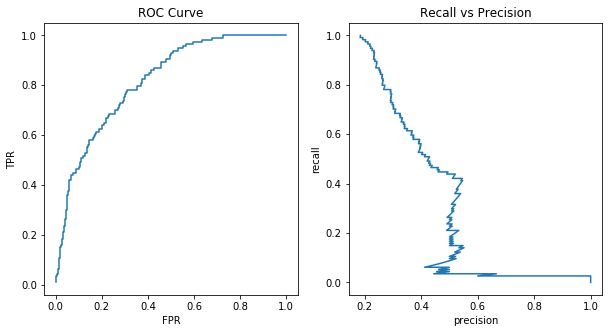

In [15]:
from sklearn import linear_model
log_reg = linear_model.LogisticRegressionCV(Cs=[1e4], cv = 10, class_weight='balanced', penalty='l2')

log_reg.fit(x_train, y_train)

model = log_reg

threshold = .6
print('\nTRAIN')
print_eval(model, x_train, y_train, threshold)

print('\nTEST')
print_eval(model, x_test, y_test,threshold)

precision, recall, thresholds = plot_precision_recall_curve(model = log_reg, x= x_test, y = y_test)

In [ ]:
svm = SVC(C=1e5, class_weight='balanced', kernel = 'linear')

print('Training SVM...')
svm.fit(x_train, y_train)

model = svm
print('\nTRAIN')
print_eval(model, x_train, y_train)

print('\nTEST')
print_eval(model, x_test, y_test)

Training SVM...


In [30]:
# svm hypertuning

import time
start_time = time.time()

param_grid = {
              "C": [1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5],
              "kernel": ['rbf', 'linear']
             }
# run grid search
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid_search.fit(x_train, y_train)

time = time.time() - start_time
print("Hyperparameter tuning took {} seconds".format(time))

Hyperparameter tuning took 5377.633442401886 seconds


In [45]:
report(grid_search.cv_results_)

Model with rank: 1
Mean validation score: 0.810 (std: 0.023)
Parameters: {'C': 100000.0, 'kernel': 'linear'}



Model with rank: 2
Mean validation score: 0.808 (std: 0.022)
Parameters: {'C': 10000.0, 'kernel': 'linear'}



Model with rank: 3
Mean validation score: 0.808 (std: 0.023)
Parameters: {'C': 1000.0, 'kernel': 'linear'}



Model with rank: 4
Mean validation score: 0.774 (std: 0.034)
Parameters: {'C': 100.0, 'kernel': 'linear'}



Model with rank: 5
Mean validation score: 0.728 (std: 0.018)
Parameters: {'C': 10.0, 'kernel': 'rbf'}



Model with rank: 6
Mean validation score: 0.725 (std: 0.020)
Parameters: {'C': 100.0, 'kernel': 'rbf'}



Model with rank: 7
Mean validation score: 0.722 (std: 0.027)
Parameters: {'C': 1000.0, 'kernel': 'rbf'}



Model with rank: 8
Mean validation score: 0.719 (std: 0.013)
Parameters: {'C': 1, 'kernel': 'rbf'}



Model with rank: 9
Mean validation score: 0.718 (std: 0.032)
Parameters: {'C': 10000.0, 'kernel': 'rbf'}



Model with rank: 10
Mean valid


TRAIN
Accuracy:       0.85218
Precision:      0.50462
Recall:         0.78926
AUC:            0.82627
F1 score:       0.61563

Confusion (rows: pred, cols: actual)
     1     0
1  382   375
0  102  2368

TEST
Accuracy:       0.65180
Precision:      0.25797
Recall:         0.78070
AUC:            0.70565
F1 score:       0.38780

Confusion (rows: pred, cols: actual)
    1    0
1  89  256
0  25  437


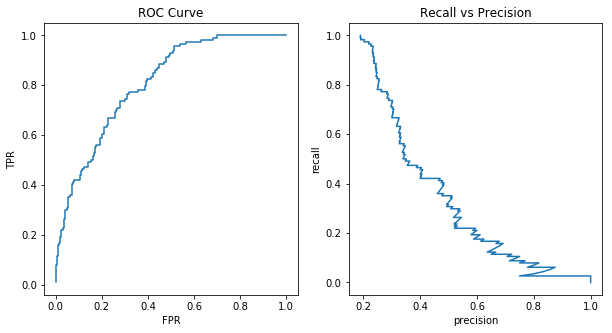

In [18]:
rf = RandomForestClassifier(bootstrap = True, criterion= 'entropy', max_depth= None, max_features= 5, min_samples_leaf= 15, min_samples_split= 10, n_estimators= 1000)
rf.fit(x_train, y_train)

threshold = .25
model = rf
print('\nTRAIN')
print_eval(model, x_train, y_train, threshold)

print('\nTEST')
print_eval(model, x_test, y_test, threshold)

precision, recall, thresholds = plot_precision_recall_curve(model = rf, x= x_test, y = y_test)

In [18]:
# random forest hypertuning

import time
start_time = time.time()

param_grid = {
              "n_estimators": [300],
              "max_depth": [15, 10, 5, None],
              "max_features": [1,5,9,13],
              "min_samples_split": [2,4,6,8,10],
              "min_samples_leaf": [5,10,15,20,25],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]
             }
# run grid search
grid_search = GridSearchCV(rf, param_grid=param_grid, cv = 5, scoring = 'roc_auc')
grid_search.fit(x_train, y_train)

time = time.time() - start_time
print("Hyperparameter tuning took {} seconds".format(time))

Hyperparameter tuning took 11554.118929624557 seconds


In [59]:
def plot_model_var_imp( model , X , y , columns):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = columns.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

0.861481251937


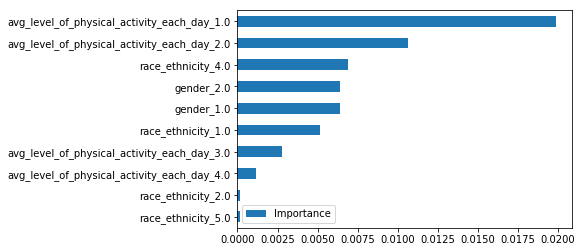

In [60]:
plot_model_var_imp(rf, x_train, y_train, x_train_raw)


TRAIN
Accuracy:       0.86117
Precision:      0.58108
Recall:         0.26653
AUC:            0.61631
F1 score:       0.36544

Confusion (rows: pred, cols: actual)
     1     0
1  129    93
0  355  2650

TEST
Accuracy:       0.79430
Precision:      0.28333
Recall:         0.29825
AUC:            0.58707
F1 score:       0.29060

Confusion (rows: pred, cols: actual)
    1    0
1  34   86
0  80  607


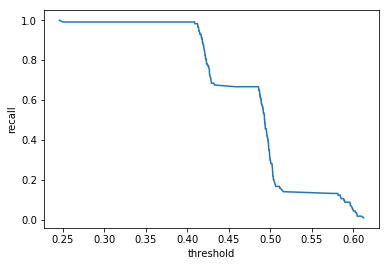

In [60]:
ada = AdaBoostClassifier()
ada.fit(x_train, y_train)

threshold = .5

model = ada
print('\nTRAIN')
print_eval(model, x_train, y_train, threshold)

print('\nTEST')
print_eval(model, x_test, y_test, threshold)

precision, recall, thresholds = plot_precision_recall_curve(model = ada, x= x_test, y = y_test)

0.861171366594


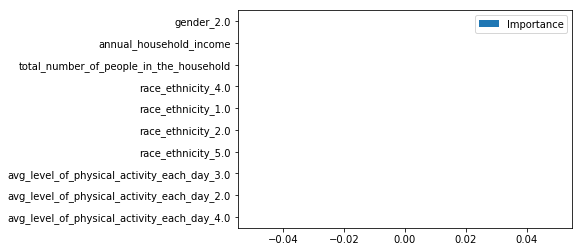

In [61]:
plot_model_var_imp(ada, x_train, y_train, x_train_raw)